## Principal Component Analysis
In machine learning and data analysis, how can we represent a data set with a huge feature space in a concise manner? How can we understand the relationship between different features? Is there a way to combine correlated features to reduce the dimensions of the dataset? Yes there is!

Dimensionality reduction is one of the most important techniques used under data pre-processing. We have all heard of the 'curse of dimensionality'. 

Read: [Curse of Dimensionality](https://www.quora.com/What-is-the-curse-of-dimensionality/answer/Yoshua-Bengio?srid=pFdM) for some good explanation.

To simplify, as the number of dimensions increase, the function to be learned becomes exponentially non-smooth. Finding a function that seperates different classes in such a high-dimensional space becomes difficult for our classifier. Hence, dimensionality reduction is used so that our original dataset can somehow be represented in lower dimensional space. This way, we are able to optimize our target function much faster. Essentially, the goal here is to convert a d-dimensional space into k-dimensional space where k &lt; d. One of the most common techniques used is Principal Component Analysis or PCA. The idea here is create a linear combination of the features such that maximum variation in the data is explained. What does that mean? Well, best way is to look at an example! Let's say we have the following feature space -

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import random
from sklearn.covariance import empirical_covariance
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA, RandomizedPCA, KernelPCA

import matplotlib.image as mpimg
from scipy import ndimage as ndi
from skimage.transform import rescale


import plotly
import plotly.plotly as py
plotly.tools.set_credentials_file(username='raunakm90', api_key='qh9wd16d6g')
import plotly.tools as tls

from plotly.graph_objs import *
%matplotlib inline

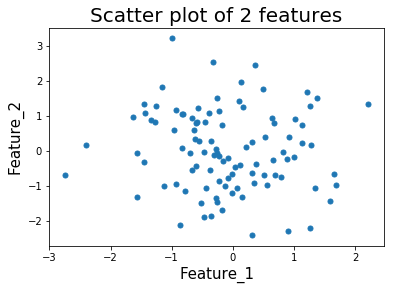

In [2]:
# Create a n*n matrix with values from standard nomral
def create_data(n = 100,d = 2):
    X = np.random.randn(n,d)
    return (X)

def plot_scatter(x,y,title,x_label,y_label):
    fig = plt.figure(figsize = (6,4))
    plt.scatter(x,y,s = 25)
    plt.title(title,size = 20)
    plt.xlabel(x_label,size = 15)
    plt.ylabel(y_label,size = 15)
    plt.show()
    fig.savefig('ScatterPlot.png')

random.seed(3)
X = create_data()
plot_scatter(X[:,0],X[:,1],x_label = 'Feature_1',y_label = 'Feature_2',
             title = 'Scatter plot of 2 features')

PCA approach has the following steps -
Standardize the data - convert data points to their corresponding z-scores
Obtain eigenvalues and eigenvectors from the covariance matrix
Sort eignevalues in descending order. Choose k eigenvectors that correspond to k largest eigenvalues
Construct a projection matrix W from the selected eigenvectors
Transform d-dimensional input dataset X using the projection matrix W to obtain the new k-dimensional feature subspace
Following chunk of code computes the eigenvalues and eigenvectors of the covariance matrix of the input dataset (as shown above)

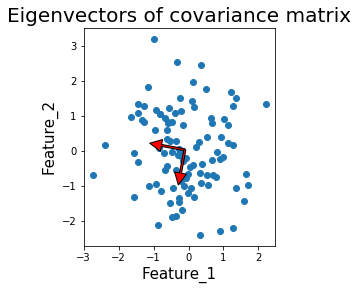

In [3]:
# Refer - http://stackoverflow.com/questions/18299523/basic-example-for-pca-with-matplotlib
cov = np.cov(X.T)
eigenvalues,eigenvectors = np.linalg.eig(cov)
projected_data = np.dot(X, eigenvectors)
mu = X.mean(axis=0)
sigma = projected_data.std(axis=0).mean()

fig, ax = plt.subplots()
ax.scatter(X[:,0],X[:,1])
for axis in eigenvectors:
    start, end = mu, mu + sigma * axis
    ax.annotate('', xy=end, xycoords='data',xytext=start, textcoords='data',
                arrowprops=dict(facecolor='red', width=2.0))
    ax.set_aspect('equal')
plt.title("Eigenvectors of covariance matrix",size = 20)
plt.xlabel("Feature_1",size = 15)
plt.ylabel("Feature_2",size = 15)
plt.show()
fig.savefig('ScatterPlot_Eigenvalues.png')

Our eigenvectors look like follows (represented in red on the graph) -

In [4]:
print(eigenvectors)

[[-0.98313134  0.18290097]
 [-0.18290097 -0.98313134]]


We have the following eigenvalues -

In [5]:
print(eigenvalues)

[ 0.81409809  1.33409121]


Since this is 2-d feature space, we select the first eigenvector to compress our data into 1-d. Therefore all the data points can be represented in the following way -

\begin{align}
-0.99*feature_1+0.007*feature_2
\end{align}

It is clear from the above equation that feature_1 contributes more in terms of magnitude than feature_2 when the project the data in the new feature space.

How do we select the number of eigenvectors (or principal components) to represent d-dimensional data in k-dimensions?

Each principal component explains a certain amount of variation in the data. This variation is explained by the eigenvalues that define the eigenvectors. We can compute the explained variance in the following manner -

$$ r_q=\frac{\sum_{j=1}^q \lambda_j}{\sum_{j=1}^p \lambda_j} $$


where the numerator denotes the eigenvalues of k principal components and denominator denotes eigenvalues of all the principal components. Hence, we can represent the explained variation in terms of percentage, which is nice and convenient!

In our toy example, variance explained is 56.13%. Ideally this number should be around 90-95% with minimum possible principal components.

## Dataset - Leaf Classification
For the following analysis, I am going to use the leaf classification dataset. Please refer the following for more details about the dataset.

Link - https://www.kaggle.com/c/leaf-classification

In [6]:
# Load the data

dataDir = './Data/'
trainData = pd.read_csv(dataDir + 'train.csv')
classEncoder = LabelEncoder()
trainLabels = classEncoder.fit_transform(trainData.ix[:,'species'])
trainIDs = np.array(trainData.ix[:,'id'])

In [7]:
numImages = 1584

shapesMatrix = np.zeros((2,numImages))
listOfImages = []
for k in range(numImages):
    imageFilename = dataDir + 'images/' + str(k+1) + '.jpg'
    currImage = mpimg.imread(imageFilename)
    shapesMatrix[:,k] = np.shape(currImage)
    listOfImages.append(currImage)

In [8]:
# The code is slightly modified from the following reference
# Reference - https://www.kaggle.com/selfishgene/leaf-classification/visualizing-pca-with-leaf-dataset
# create a large 3d array with all images
maxShapeSize = shapesMatrix.max(axis=1)
for k in range(len(maxShapeSize)):
    if maxShapeSize[k] % 2 == 0:
        maxShapeSize[k] += 311
    else:
        maxShapeSize[k] += 310

fullImageMatrix3D = np.zeros(np.hstack((maxShapeSize,np.shape(shapesMatrix[1]))).astype(int),dtype=np.dtype('u1'))
destXc = (maxShapeSize[1]+1)/2; destYc = (maxShapeSize[0]+1)/2
for k, currImage in enumerate(listOfImages):
    Yc, Xc = ndi.center_of_mass(currImage)
    Xd = destXc - Xc; Yd = destYc - Yc
    fullImageMatrix3D[int(round(Yd)):int(round(Yd)+np.shape(currImage)[0]),int(round(Xd)):int(round(Xd)+np.shape(currImage)[1]),k] = currImage

xValid = fullImageMatrix3D.mean(axis=2).sum(axis=0) > 0
yValid = fullImageMatrix3D.mean(axis=2).sum(axis=1) > 0
xLims = (np.nonzero(xValid)[0][0],np.nonzero(xValid)[0][-1])
yLims = (np.nonzero(yValid)[0][0],np.nonzero(yValid)[0][-1])
fullImageMatrix3D = fullImageMatrix3D[yLims[0]:yLims[1],xLims[0]:xLims[1],:]

##%% scale down all images
rescaleFactor = 0.30

scaledDownImage = rescale(fullImageMatrix3D[:,:,0],rescaleFactor)
scaledDownImages = np.zeros(np.hstack((np.shape(scaledDownImage),np.shape(fullImageMatrix3D)[2])),dtype=np.dtype('f4'))
for imInd in range(np.shape(fullImageMatrix3D)[2]):
    scaledDownImages[:,:,imInd] = rescale(fullImageMatrix3D[:,:,imInd],rescaleFactor)

del fullImageMatrix3D

Let's take a look at a sample of the images

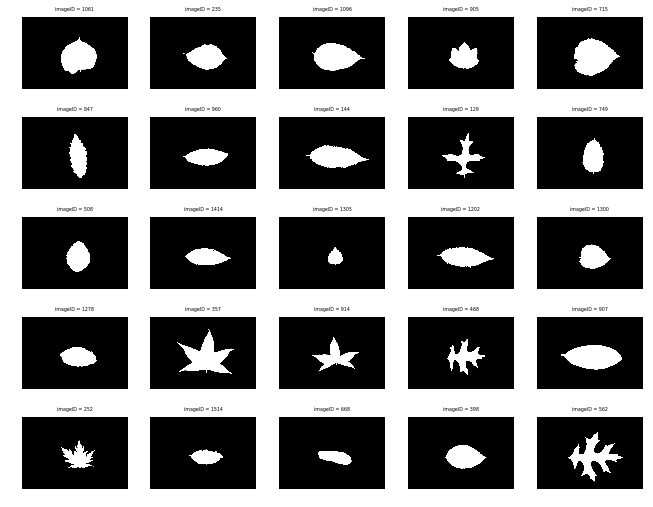

In [9]:
matplotlib.rcParams['font.size'] = 4
matplotlib.rcParams['figure.figsize'] = (9,7)    
def plot_gallery(imgs):
    np.random.seed(1) # use a nice looking random seed
    plt.figure()
    for k in range(25):
        randInd = np.random.randint(np.shape(imgs)[2])
        plt.subplot(5,5,k+1); plt.imshow(imgs[:,:,randInd], cmap='gray'); plt.axis('off')
        plt.title('imageID = ' + str(randInd))
    plt.tight_layout()
plot_gallery(scaledDownImages)

The following class is defined to fit a PCA model and perform other related functions on an image dataset

In [10]:
class PCA_model:
    def __init__(self, X, h, w, n_components=10,pca_type=None):
        '''
        X          - number of samples x number of dimensions matrix
        n_components - PCA components to be used
        h,w        - height and width of the image
        '''
        
        self.n_components = n_components
        self.h = h
        self.w = w
        if pca_type == None:
            print ("Extracting the top %d eigenvalues for %d leaves" %(n_components, X.shape[0]))
            PCAModel = PCA(n_components=n_components, svd_solver = 'full') #Run exact SVD
            print(PCAModel)
            %time self.PCAData = PCAModel.fit_transform(X)
            self.PCAModel = PCAModel
        elif pca_type == 'Randomized':
            print ("Extracting the top %d eigenvalues from %d leaves using Randomized PCA" %(n_components, X.shape[0]))
            PCAModel = PCA(n_components=n_components, svd_solver='randomized') #Run randomized PCA
            print(PCAModel)
            %time self.PCAData = PCAModel.fit_transform(X)
            self.PCAModel = PCAModel
        elif pca_type == 'Kernel':
            print ("Extracting the top %d eigenvalues from %d leaves using Kernel PCA" %(n_components, X.shape[0]))
            PCAModel = KernelPCA(n_components=n_components,kernel = 'rbf',
                                fit_inverse_transform = True, gamma = 15) #very sensitive to gamma
            print(PCAModel)
            %time self.PCAData = PCAModel.fit_transform(X)
            self.PCAModel = PCAModel
        
    def plot_explained_variance(self):
        explained_var = self.PCAModel.explained_variance_ratio_
        cum_var_exp = np.cumsum(explained_var)        
        plot_url = py.plot({
                "data": [Bar(y=explained_var, name='Individual explained variance'),
                         Scatter(y=cum_var_exp, name='Cumulative explained variance')],
                "layout": Layout(xaxis=XAxis(title='Principal components'), yaxis=YAxis(title='Explained variance ratio'))
                            }, filename = 'ReviewCount-Neighborhood', auto_open=False)
        return (tls.get_embed(plot_url))
        
    def ReconstructImage(self, img):
        pca_rep = self.PCAModel.transform(img)
        rec_img = self.PCAModel.inverse_transform(pca_rep)
        return rec_img
    
    def showReconstructImage(self, X, numReconstruct = 5):
        numSamples = X.shape[0]
#         np.random.seed(1) # use a nice looking random seed
        numSamperFig = min(5,numReconstruct)
        numFig = int(np.ceil(numReconstruct/numSamperFig))
        
        for fig in range(numFig):
            plt.figure()
            for col in range(numSamperFig):
                imgInd = np.random.randint(numSamperFig)
                img = X[imgInd,:].reshape(1,-1) #only 1 sample
                reconstruct_img = self.ReconstructImage(img)
                diff_img = abs(img - reconstruct_img)
            
                # Plot original image
                plt.subplot(3,numSamperFig,0*numSamperFig+col+1)
                plt.title('Original Image')
                plt.imshow(img.reshape(self.h,self.w),cmap=plt.cm.gray)
                plt.axis('off')
                
                # Plot the reconstructed image
                plt.subplot(3,numSamperFig,1*numSamperFig+col+1)
                plt.title('Reconstructed Image')
                plt.imshow(reconstruct_img.reshape(self.h,self.w),cmap=plt.cm.gray)
                plt.axis('off')
                
                # Plot the difference image
                plt.subplot(3,numSamperFig,2*numSamperFig+col+1)
                plt.title('Difference Image')
                plt.imshow(diff_img.reshape(self.h,self.w),cmap=plt.cm.gray)
                plt.axis('off')
            plt.tight_layout()

In [11]:
sampleDim = np.shape(scaledDownImages)[0]*np.shape(scaledDownImages)[1]
X = scaledDownImages.reshape(sampleDim,-1).T
print("Number of samples: {}".format(X.shape[0]))
print("Number of features: {}".format(X.shape[1]))
print("Original Image size: {} by {}".format(np.shape(scaledDownImages)[0],np.shape(scaledDownImages)[1]))

Number of samples: 1584
Number of features: 169161
Original Image size: 339 by 499


In [12]:
pca = PCA_model(X,np.shape(scaledDownImages)[0], np.shape(scaledDownImages)[1],n_components=500)

Extracting the top 500 eigenvalues for 1584 leaves
PCA(copy=True, iterated_power='auto', n_components=500, random_state=None,
  svd_solver='full', tol=0.0, whiten=False)
Wall time: 1min 22s


Reconstruct the images from their components.

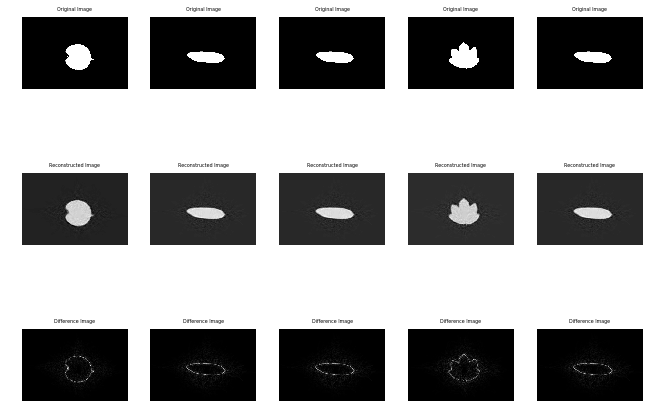

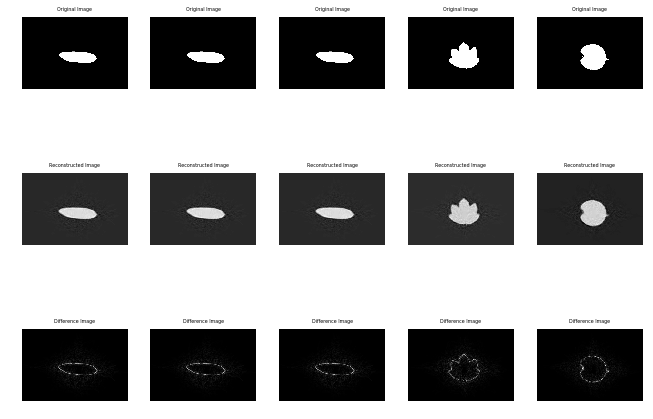

In [13]:
pca.showReconstructImage(X, numReconstruct=10)

In [14]:
pca.plot_explained_variance()

'<iframe id="igraph" scrolling="no" style="border:none;" seamless="seamless" src="https://plot.ly/~raunakm90/42.embed" height="525" width="100%"></iframe>'

200 principal components are able to about 91% of the variation

## Randomized PCA

Randomized PCA uses singular value decomposition for the approximating the decomposition of a given matrix. It is good for a dataset with large number of features as it decomposes quicker than the normal PCA. For detailed understanding, refer the [this manuscript](https://arxiv.org/abs/0909.4061).

In [15]:
rpca = PCA_model(X,np.shape(scaledDownImages)[0], np.shape(scaledDownImages)[1],
                 n_components=500, pca_type ='Randomized')

Extracting the top 500 eigenvalues from 1584 leaves using Randomized PCA
PCA(copy=True, iterated_power='auto', n_components=500, random_state=None,
  svd_solver='randomized', tol=0.0, whiten=False)
Wall time: 5min 23s


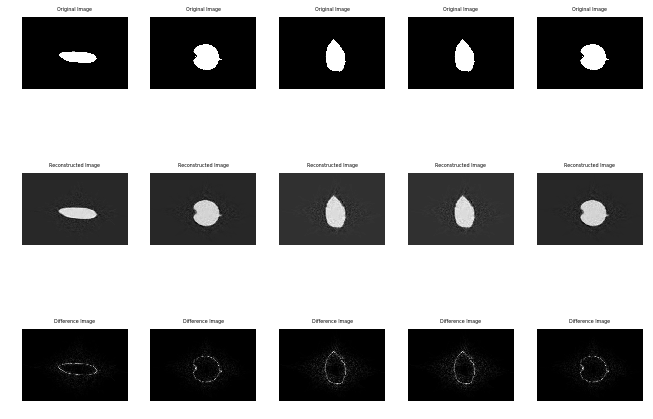

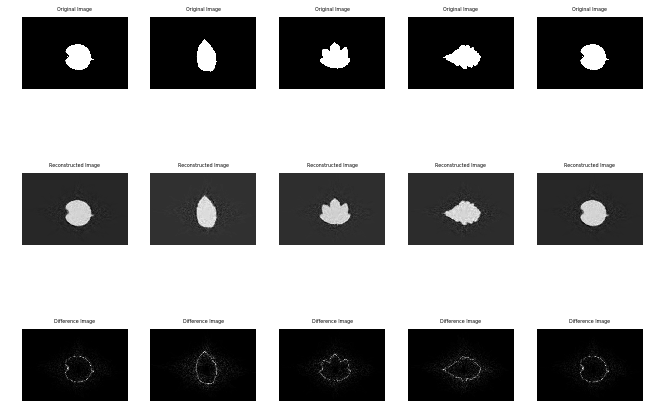

In [16]:
rpca.showReconstructImage(X, numReconstruct=10)

In [17]:
rpca.plot_explained_variance()

'<iframe id="igraph" scrolling="no" style="border:none;" seamless="seamless" src="https://plot.ly/~raunakm90/42.embed" height="525" width="100%"></iframe>'

Since our dataset is not big enough, our approximation is equal to the true value and we have the same results as before. The only difference is that it runs a little faster than before.

## Kernel PCA

Kernel's allow us to transform data into a higher dimensional plane. The idea is if a given dataset is not linearly seperable in d-dimensions, then we transform the data into N-dimensions (N > d) so that it is linearly seperable. Kernel PCA implies that the data is first transformed using a kernel like RBF (radial-basis function) and PCA is applied in this higher dimension. 

In the following example, let's try the kernel PCA with rbf-kernel on the leaves dataset.

In [18]:
kpca = PCA_model(X, np.shape(scaledDownImages)[0], np.shape(scaledDownImages)[1],
                 n_components=500, pca_type ='Kernel')

Extracting the top 500 eigenvalues from 1584 leaves using Kernel PCA
KernelPCA(alpha=1.0, coef0=1, copy_X=True, degree=3, eigen_solver='auto',
     fit_inverse_transform=True, gamma=15, kernel='rbf',
     kernel_params=None, max_iter=None, n_components=500, n_jobs=1,
     random_state=None, remove_zero_eig=False, tol=0)
Wall time: 49 s


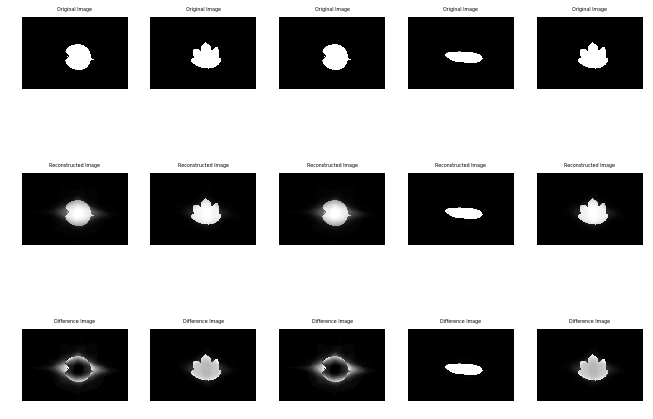

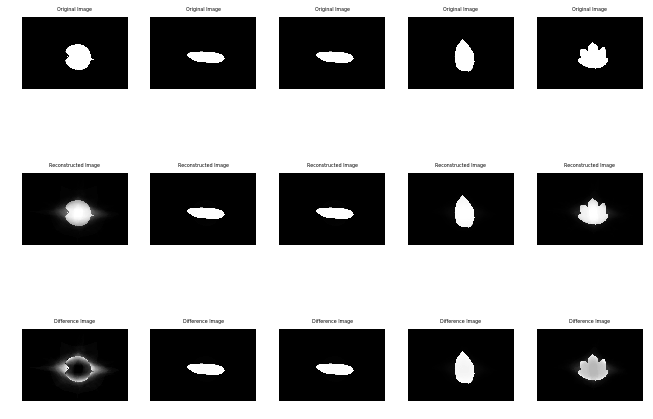

In [19]:
kpca.showReconstructImage(X, numReconstruct=10)

In [20]:
import warnings
warnings.simplefilter('ignore', DeprecationWarning)

from ipywidgets import widgets  # make this interactive!

# compare the different methods
h = np.shape(scaledDownImages)[0]
w = np.shape(scaledDownImages)[1]
n_samples = X.shape[0]

def plt_reconstruct(idx_to_reconstruct):
    idx_to_reconstruct = np.round(idx_to_reconstruct)
    
    reconstructed_image = pca.PCAModel.inverse_transform(pca.PCAModel.transform(X[idx_to_reconstruct]))
#     reconstructed_image_rpca = rpca.PCAModel.inverse_transform(rpca.PCAModel.transform(X[idx_to_reconstruct]))
    reconstructed_image_kpca = kpca.PCAModel.inverse_transform(kpca.PCAModel.transform(X[idx_to_reconstruct]))
    
    
    plt.figure(figsize=(15,7))
    
    plt.subplot(1,3,1)
    plt.imshow(X[idx_to_reconstruct].reshape((h, w)), cmap=plt.cm.gray)
    plt.title('Original')
    
    plt.subplot(1,3,2)
    plt.imshow(reconstructed_image.reshape((h, w)), cmap=plt.cm.gray)
    plt.title('Full PCA')
    '''
    plt.subplot(1,4,3)
    plt.imshow(reconstructed_image_rpca.reshape((h, w)), cmap=plt.cm.gray)
    plt.title('Randomized PCA')
    '''
    plt.subplot(1,3,3)
    plt.imshow(reconstructed_image_kpca.reshape((h, w)), cmap=plt.cm.gray)
    plt.title('Kernel PCA')
    
widgets.interact(plt_reconstruct,idx_to_reconstruct=(0,n_samples-1,1),__manual=True)

<function __main__.plt_reconstruct>